# FV Shear estimation

In [1]:
# %
# % Test for shear modulus estimation using inner displacements
# %
# % We consider the simplified elasticity model for a given displacement
# % field 'u' :
# %
# % -rho*w^2*u - div(G*grad(u)) = 0   at each voxel
# %
# % Then, after integration over each voxel and, assuming that
# % G is piecewise constant and rho=1 [gr/cm^3], we obtain the vectorial
# % system for each G(voxel) as follows:
# % 
# % G = -rho*w^2 * dot(b,p)/dot(b,b)  at each voxel
# %
# % where
# %
# % b = int_{voxel boundary} e(u)*nds   (integration on the surface)
# % p = int_{voxel} u dx                (integration in the voxel)
# %  
# % with e(u) = 1/2 (grad(u) + grad(u)^T) is the linear strain tensor.
# %
# %
# % Joaquin Mura (2017)
# %

import scipy.io as sio
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# some physical parameters
dx  = 1e-3; # 1 mm
dy  = 1e-3;
dz  = 1e-3;
rho = 1e+3; # 1 g/cm^3

# Color axis limits
Gmin = 2.5e3; #  2.5 KPa
Gmax = 1.05e4;# 10.5 KPa

# simulated frequencies: 50Hz, 60Hz, 70Hz and 80Hz
freq = [50,60,70,80];

mat_contents = sio.loadmat('./data/sim.mat')
U = mat_contents['U']

In [92]:
def show_images(Uc,i,n):
    for k in range(0,n):
        plt.title("Slice " + str(k))
        plt.imshow(abs(Uc[:,:,k,i,0]))
        plt.colorbar()
        plt.show()

'''
function Du = DUdxdy(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(front-back) du/dx_i dxdy

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdy(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[1]*(u[i-1,j,k+1] + u[i+1,j,k-1] - u[i+1,j,k+1] - u[i-1,j,k-1])
    Du[1] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    Du[2] = D[0]*D[1]/D[2]*(u[i,j,k+1] - 2*u[i,j,k] + u[i,j,k-1])
    return Du

   
'''
function Du = DUdxdz(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(north-south) du/dx_i dxdz

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdz(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[2]*(u[i-1,j+1,k] + u[i+1,j-1,k] - u[i+1,j+1,k] - u[i-1,j-1,k])
    Du[1] = D[0]*D[2]/D[1]*(u[i,j+1,k] - 2*u[i,j,k] + u[i,j-1,k])
    Du[2] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    return Du


'''
function Du = DUdydz(u,[dx,dy,dz],i,j,k)

 Evaluate local term for int_(east-west) du/dx_i dydz

 matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdydz(u,D,i,j,k):

    Du = [0,0,0]
    Du[0] = (D[1]*D[2]/D[0])*( u[i+1,j,k] - 2*u[i,j,k] + u[i-1,j,k] )
    Du[1] = 0.25*D[2]*(u[i+1,j+1,k] - u[i+1,j-1,k] - u[i-1,j+1,k] + u[i-1,j-1,k])
    Du[2] = 0.25*D[1]*(u[i+1,j,k+1] - u[i+1,j,k-1] - u[i-1,j,k+1] + u[i-1,j,k-1])
    return Du

In [93]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'U'])

In [94]:
# The data is 6D: y, x, z, time steps, encoding direction, frequency
[ny,nx,nz,nt,_nenc,nf]  = U.shape


In [95]:
U_fft = fft(U,axis=3)
Uc    = np.squeeze(U_fft[:,:,:,1,:,:]);
[X,Y,Z] = np.mgrid[0:nx*dx:dx,0:ny*dy:dy,0:nz*dz:dz]

In [98]:
f = 0
# Ux = squeeze(Uc(:,:,:,2,:));
# Uy = squeeze(Uc(:,:,:,1,:));
# Uz = squeeze(Uc(:,:,:,3,:));
Ux = Uc[:,:,:,1,f]
Uy = Uc[:,:,:,0,f]
Uz = Uc[:,:,:,2,f]

for i in range(0,nx-1):
    for j in range(0,ny-1):
        for k in range(0,nz-1):
            volume = dx*dy*dz
            p = [Ux[i,j,k]*volume, Uy[i,j,k]*volume, Uz[i,j,k]*volume]
            
            dV = [dx,dy,dz]
            Uxxy = DUdxdy(Ux,dV,i,j,k)
            Uyxy = DUdxdy(Uy,dV,i,j,k)
            Uzxy = DUdxdy(Uz,dV,i,j,k)
            Uxxz = DUdxdz(Ux,dV,i,j,k)
            Uyxz = DUdxdz(Uy,dV,i,j,k)
            Uzxz = DUdxdz(Uz,dV,i,j,k)
            Uxyz = DUdydz(Ux,dV,i,j,k)
            Uyyz = DUdydz(Uy,dV,i,j,k)
            Uzyz = DUdydz(Uz,dV,i,j,k)
            bx = [Uxyz[0], 0.5*(Uxyz[1]+Uyyz[0]), 0.5*(Uxyz[2]+Uzyz[0])]
            by = [0.5*(Uxxz[1]+Uyxz[0]), Uyxz[1], 0.5*(Uyxz[2]+Uzxz[1])]
            bz = [0.5*(Uxxy[2]+Uzxy[0]), 0.5*(Uyxy[2]+Uzxy[1]), Uzxy[2]]
            b = [bx[n] + by[n] + bz[n] for n in range(0,3)]
            
            # Evaluation of shear modulus
            G[i,j,k] =-rho*(2*np.pi*freq[f])**2/abs(np.vdot(b,b))*abs(np.vdot(b,p))
            

            


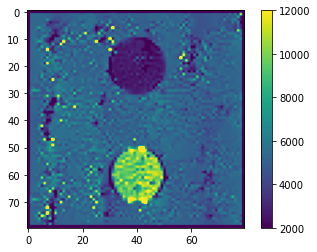

In [102]:
plt.imshow(abs(G[:,:,1]))
plt.colorbar()
plt.clim(2000,12000) 
plt.savefig('/Users/caiazzo/Desktop/g.png')